![input video](https://media.giphy.com/media/IhPDeuUS6MPi92Yxii/giphy.gif)

Above video consists of several topics with multiple choices, all presented in a rectangle. Each question has a keyword included in its body; different questions have different keywords. I define a task to retrieve all frames display a wanted question based on a keyword I input. After that, I will select a concrete frame where it can exhibit my wanted question and associated answers to my query. For example, my expectation if I use **Wine** as the keyword is bellow. 

Output video: ![output video](https://media.giphy.com/media/kbWm3OCVwG4FETLbo2/giphy.gif)

Output image: <img src="output.jpg" />

In [1]:
%load_ext autotime

In [2]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

time: 2.53 s


In [3]:
def generate_image_path(index, folder):
    return f"{folder}/frame_{index}.jpg"

time: 542 µs


I assume that readers installed OpenCV, Tesseract, Pytorch, other libraries, and cloned CRAFT-pytorch to current working folder

In [36]:
# notebook parameters

args = {
    'canvas_size': 1280, 
    'cuda': False, 
    'link_threshold': 0.4, 
    'low_text': 0.4, 
    'mag_ratio': 1.5, 
    'poly': False, 
    'refine': False,
    'show_time': False, 
    "test_folder": './figures', 
    'text_threshold': 0.7, 
    'trained_model': './weights/craft_mlt_25k.pth',
    'refine': False,
    'video': './video.mp4',
    'sampling_rate': 17,
    'keyword': 'wine',
    'word_similarity': 0.7
}

time: 985 µs


# analysis

## text detector & recognization

It is natural to use text detection approaches to extract texts, then using keyword matching to get the appropriate targeted question. In literature, text detection can achieve good performance with CNN-net-based methods that stack consecutive convolution blocks and a classifier on the top layer to predict text area. **EAST** has been a popular method since 2017. Recently, a new technique, namely **CRAFT**, have been invented with a significant improvement, especially images influenced in high variant environmental condition.

EAST: https://arxiv.org/abs/1704.03155

CRAFT: https://arxiv.org/abs/1904.01941

I have a quick valuation to determine which method is more appropriate in my task. Below is my comparison of the output of each method which shows that **CRAFT outperformed**

<img src="craft_vs_east.png" />


When text areas are detected, I need to feed bounding boxes through text recognition. Text recognization can be done via CNN+LSTM (e.g https://arxiv.org/pdf/1507.05717.pdf). In particular, I use Tesseract's implementation

Tesseract's Architecture: https://tesseract-ocr.github.io/docs/das_tutorial2016/2ArchitectureAndDataStructures.pdf

## histogram differentiation

There are some observations can help

1. a segment can be divided into 2 phases, one of them is when no answer is given. There are short periods where the box contains question doesn't change much in terms of size, colors to give time for responses. 
2. detect rectangle and its size can track phases, potentially support to finalize a frame
3. the question box has a transparent color, strongly influenced by colors from the background hence it is hard for image processing techniques such as Canny edge detector, Hough transform.
4. from point #1, we can leverage the difference between frames

**sampling_video** extracts frames from videos while sampling frame with a fixed frequency (default is 17)

In [5]:
def sampling_video(video_path: str, extracted_frames_path: str, freq:int = 17) -> dict:
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    frames_dict = {}
    while success:
        file_name = f"{extracted_frames_path}/frame_{count}.jpg"
        if count % freq == 0:
            frames_dict[count] = file_name
        cv2.imwrite(file_name, image)    # save frame as JPEG file      

        success,image = vidcap.read()
        count += 1

    return frames_dict, count

image_paths, total_frames = sampling_video(args['video'], args['test_folder'], args['sampling_rate'])

time: 17.5 s


## explore observation #4

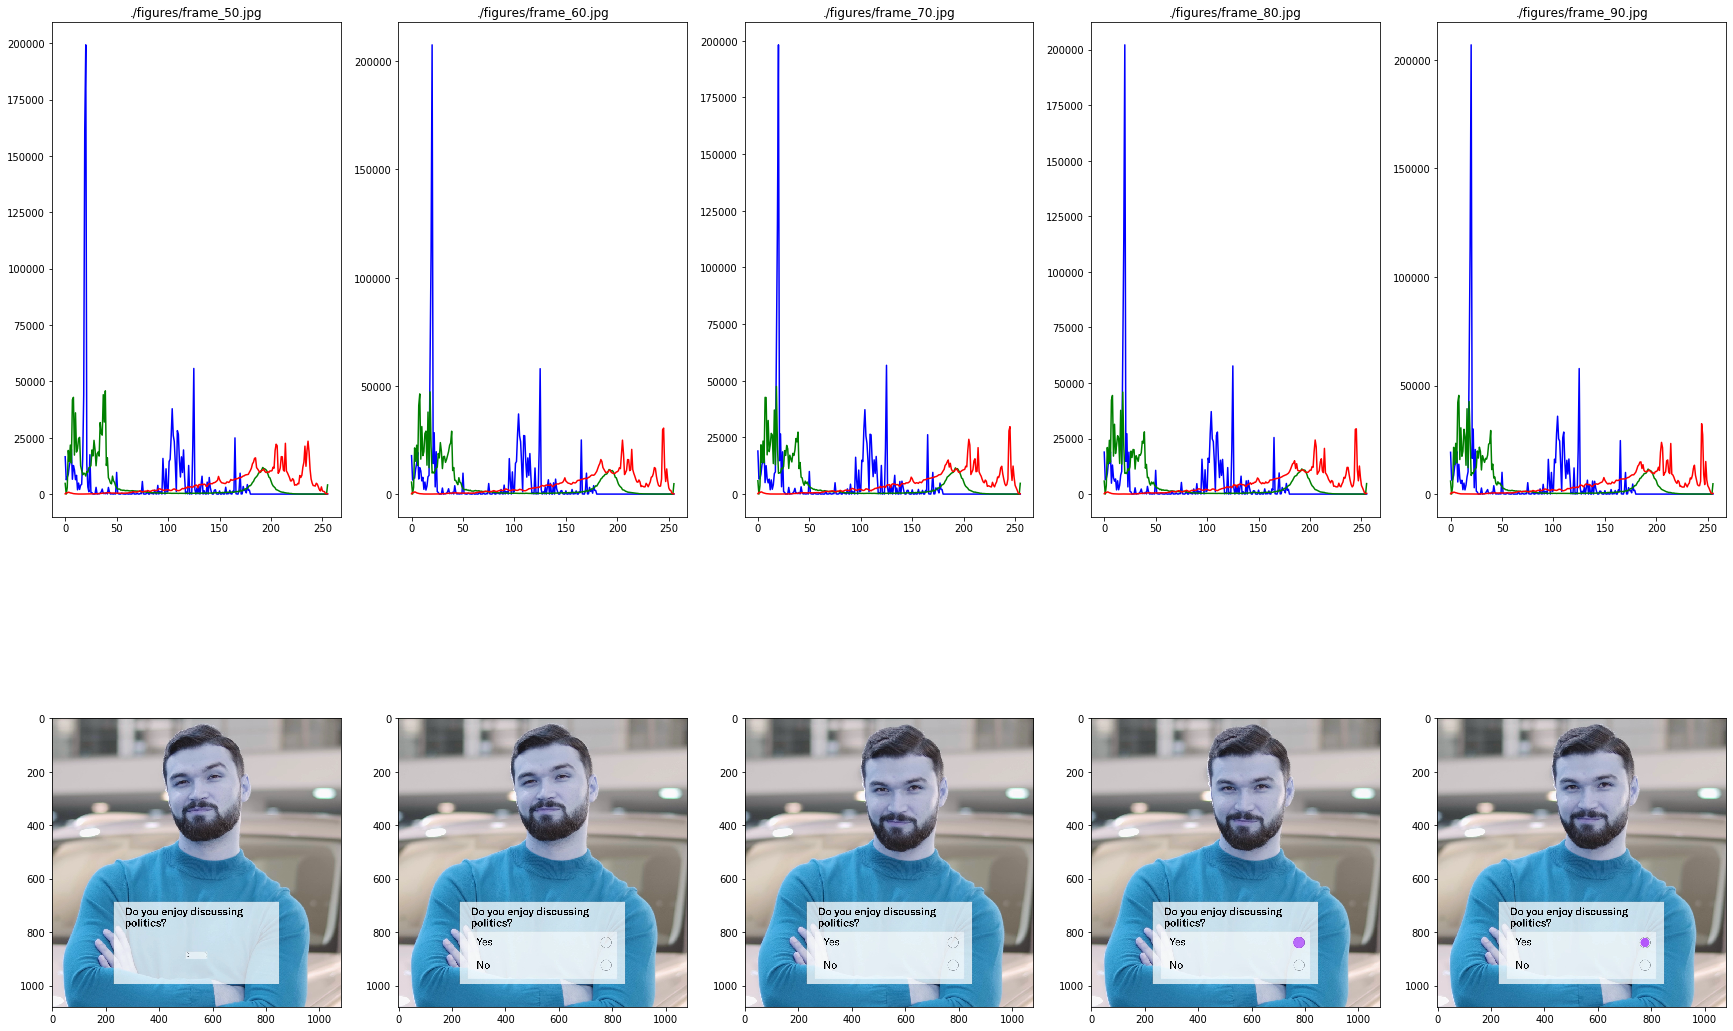

time: 2.05 s


In [6]:
seed_list = [f"{args['test_folder']}/frame_{i}.jpg" for i in range(50,100, 10)]

n = len(seed_list)
color = ('b','g','r')

fig, axs = plt.subplots(2, n, figsize=(30, 20))

for i in range(1, n+1):
    m = cv2.imread(seed_list[i-1])
    hsv = cv2.cvtColor(m,cv2.COLOR_BGR2HSV)

    for j,col in enumerate(color):
        histr = cv2.calcHist([hsv],[j],None,[256],[0,256])
        axs[0][i-1].plot(histr,color = col)
        axs[0][i-1].set_title(seed_list[i-1])
        axs[1][i-1].imshow(m)
plt.show()

use histogram to calculate differentiation, examine frames whose indexes are from 48 to 103

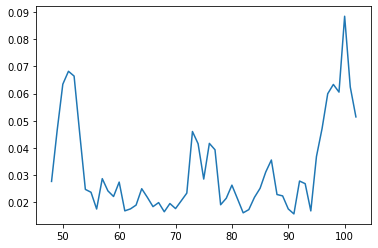

time: 2.26 s


In [7]:
diffs = []

start = 48
end = 103


def hist_diff(img1_path, img2_path):
    # Load the images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Convert it to HSV
    img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    img2_hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

    # Calculate the histogram and normalize it
    hist_img1 = cv2.calcHist([img1_hsv], [0], None,[256],[0,256])
    cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX);
    hist_img2 = cv2.calcHist([img2_hsv], [0], None,[256],[0,256])
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX);

    # find the metric value
    metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_HELLINGER)
    
    return metric_val

for i in tqdm(range(start, end)):
    img1 = generate_image_path(i, args['test_folder'])
    img2 = generate_image_path(i+3, args['test_folder'])
    diff = hist_diff(img1, img2)
    diffs.append(diff)
    
plt.plot(range(start, end), diffs)

Let me make histogram smoother

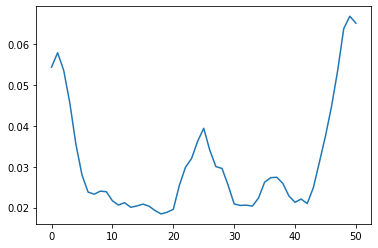

time: 110 ms


In [8]:
def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

avg_diffs = moving_average(diffs, 5)

plt.plot(avg_diffs)

Histogram diff small reflect short periods when consecutive frame keeps the same, otherwise, an event occurs to change image details dramatically (increase red pixels as an answer is checked or reduce while pixel as rectangle shrinks)

Recall observation #1, my target frame locates in the second flat phase of histogram difference. Local minima can leverage to spot out interested frame

<img src="histogram_diff.png" />

Double-check frames in the second flat phase of histogram difference to make sure **NO SIGNIFICANT DIFFERENCE**, that has been said that I can use an arbitrary frame in this area

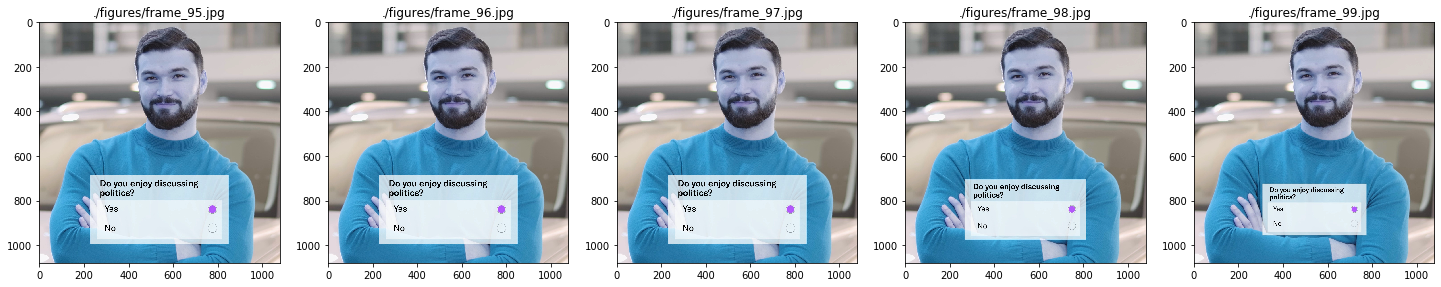

time: 1.48 s


In [9]:
seed_list = [f"{args['test_folder']}/frame_{i}.jpg" for i in range(95,100)]
n = len(seed_list)

fig, axs = plt.subplots(1, n, figsize=(25, 25))

for i in range(1, n+1):
    m = cv2.imread(seed_list[i-1])
    
    for j,col in enumerate(color):
        axs[i-1].set_title(seed_list[i-1])
        axs[i-1].imshow(m)
plt.show()

# approach

## preliminary

In [ ]:
!git clone https://github.com/clovaai/CRAFT-pytorch.git && cp CRAFT-pytorch/* .

In [10]:
result_folder = './weights/'
if not os.path.isdir(result_folder):
    os.mkdir(result_folder)

time: 714 µs


get pre-trained params at https://drive.google.com/open?id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ and save at folder **weights** and name **craft_mlt_25k.pth**

## implementation

1. Sampling video
2. For image in sampled frames
+ Pass sampled frames to text detector + text recognization (treat the image as a single word)
+ If a frame consist input keyword --> append to **target_indexes** 
3. Find leftmost and rightmost index from **target_indexes** 
4. Expand left and right to cover all frames have keyword
5. Compute **hist_diff** and find local minima
6. Return interested frame & the part of video


## step 2 & 3

In [16]:
import file_utils

image_list, _, _ = file_utils.get_files(args['test_folder'])

result_folder = './result/'
if not os.path.isdir(result_folder):
    os.mkdir(result_folder)

def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, canvas_size, mag_ratio, refine_net=None):

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    return boxes, polys, ret_score_text

time: 7.17 ms


**similar** compute similarity between 2 words

In [20]:
from difflib import SequenceMatcher
import re

def text_preproc(text):
    new_text = text.lower()
    new_text = re.sub('[^A-Za-z0-9]+', '', new_text)
    return new_text


def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

time: 1.11 ms


In [13]:
from craft import CRAFT
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import craft_utils
import imgproc
import file_utils

from collections import OrderedDict
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

net = CRAFT()     # initialize

print('Loading weights from checkpoint (' + args['trained_model'] + ')')
if args['cuda']:
    net.load_state_dict(copyStateDict(torch.load(args['trained_model'])))
else:
    net.load_state_dict(copyStateDict(torch.load(args['trained_model'], map_location='cpu')))

if args['cuda']:
    net = net.cuda()
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = False

net.eval()

Loading weights from checkpoint (./weights/craft_mlt_25k.pth)


CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kerne

time: 3.75 s


In [18]:
import pytesseract

def extract_text(blob, box):
    startY = int(box[0][1])
    endY = int(box[2][1])
    startX = int(box[0][0])
    endX = int(box[2][0])
    
    roi = blob[startY:endY, startX:endX]
    
    configuration = ("-l eng --oem 1 --psm 8")  # Neural nets LSTM engine only + Treat the image as a single word.
    
    t = pytesseract.image_to_string(roi, config=configuration)
    
    return t, roi

def text_recognization(image, bboxes):
    nobjs = bboxes.shape[0]
    text_locations = {}
    
    for i in range(1, nobjs+1):
        text , image_area = extract_text(image, bboxes[i-1])
        text_locations[i-1] = text, bboxes[i-1]
    return text_locations

time: 13.5 ms


For each image from which I get texts. Based on **word_similarity**, I note interested frame. Later I find *leftmost* and *rightmost*

In [21]:
# load data
target_indexes = {}
fmin = 999999
fmax = -1


for image_index in tqdm(image_paths.keys()):
    
    image_path = image_paths[image_index]
    image = imgproc.loadImage(image_path)

    bboxes, polys, score_text = test_net(net, image, args['text_threshold'], args['link_threshold'], 
                                         args['low_text'], args['cuda'], args['poly'], args['canvas_size'], args['mag_ratio'])
    
    text_locations = None
    if hasattr(bboxes,'shape'):
        text_locations = text_recognization(image, bboxes)
        for k in text_locations.keys():
            score = similar(args['keyword'], text_locations[k][0])
            if score >= args['word_similarity']:
                target_indexes[image_index] = text_locations[k]
                
                fmax = max(fmax, image_index)
                fmin = min(fmin, image_index)
                
                file_utils.saveResult(image_path, image[:,:,::-1], polys, dirname=result_folder, texts=text_locations)


time: 10min 12s


## step 4

I use a sort of binary search to expand both left and right direction. First, perform search with a large window size (default **w_expand** = 10). If a frame doesn't consist my target keyword, window size is shrinked a half

In [22]:
def frame_check(frame, net, **kargs):
    image = imgproc.loadImage(generate_image_path(frame, kargs['test_folder']))
    bboxes, polys, score_text = test_net(net, image, kargs['text_threshold'], kargs['link_threshold'], 
                                         kargs['low_text'], kargs['cuda'], kargs['poly'], kargs['canvas_size'], kargs['mag_ratio'])
    flag = False
    text_locations = None
    if hasattr(bboxes,'shape'):
        text_locations = text_recognization(image, bboxes)
        for k in text_locations.keys():
            score = similar(kargs['keyword'], text_locations[k][0])
            if score >= kargs['word_similarity']:
                flag = True
                break
    return flag

def left_check(pivot, w_expand, net, **kargs):
    f_left = pivot - w_expand
    is_exist = frame_check(f_left, net, **kargs)
    if is_exist:
        return left_check(f_left, w_expand, net, **kargs)
    else:
        if pivot - f_left > 1:
            return left_check(pivot, int(w_expand/2), net, **kargs)
        else:
            return pivot
    

def right_check(pivot, w_expand, net, **kargs):
    f_right = pivot + w_expand
    is_exist = frame_check(f_right, net, **kargs)
    if is_exist:
        return right_check(f_right, w_expand, net, **kargs)
    else:
        if f_right - pivot > 1:
            return right_check(pivot, int(w_expand/2), net, **kargs)
        else:
            return pivot

def check(f_left, r_right, net, w_expand = 10, **kargs):
    l_point = left_check(f_left, w_expand, net, **kargs)
    r_point = right_check(r_right, w_expand, net, **kargs)
    return l_point, r_point


mmin, mmax = check(fmin, fmax, net, **args)

time: 2min 54s


In [35]:
import imageio

def generate_video(start, end, in_folder, output='output.gif'): 
    
    with imageio.get_writer(output, mode='I') as writer:
        for i in range(start, end+1):
            image = imageio.imread(generate_image_path(i, in_folder))
            writer.append_data(image)

generate_video(mmin, mmax, args['test_folder'])

time: 13.5 s


**generate_video** aggregates frames what I found after performing **check** function and exports them to a GIF (output.gif)

<img src="output.gif" />

## step 5

In [37]:
import numpy as np
from scipy.signal import argrelextrema

def hist_diff(img1_path, img2_path):
    # Load the images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Convert it to HSV
    img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    img2_hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

    # Calculate the histogram and normalize it
    hist_img1 = cv2.calcHist([img1_hsv], [0], None,[256],[0,256])
    cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX);
    hist_img2 = cv2.calcHist([img2_hsv], [0], None,[256],[0,256])
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX);

    # find the metric value
    metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_HELLINGER)
    
    return metric_val

def find_interested_frame(mmin, mmax, moving_window = 5, local_window=2):
    diffs = []
    for i in tqdm(range(mmin, mmax)):
        img1 = generate_image_path(i, args['test_folder'])
        img2 = generate_image_path(i+3, args['test_folder'])
        diff = hist_diff(img1, img2)
        diffs.append(diff)
    avg_diffs = moving_average(diffs, moving_window)
    data = np.array(avg_diffs)
    
    r = argrelextrema(data, np.less, order=local_window)
    k = r[0][-1]+moving_window-1  # revert frame index like before applying moving average
    
    frame_index = mmin+k  # change coordinate to video frame index
    
    return frame_index , diffs, avg_diffs


interested_frame_index, diffs, ma_diffs = find_interested_frame(mmin, mmax)


time: 2.23 s


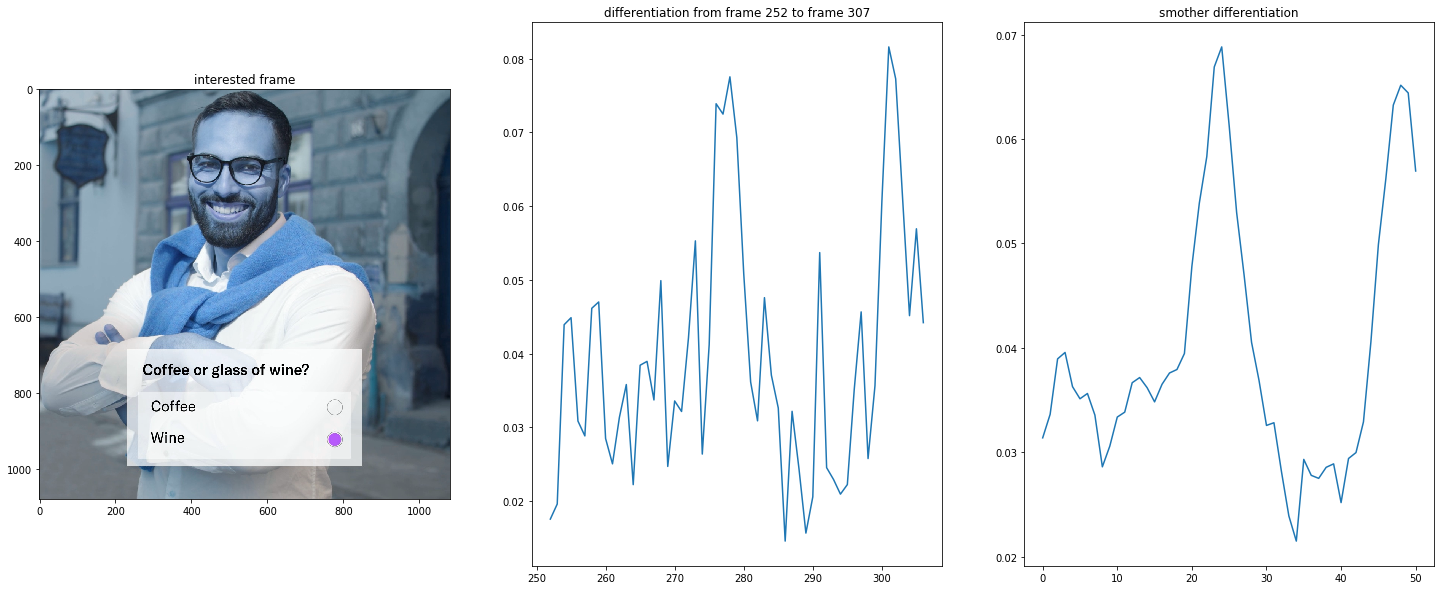

time: 534 ms


In [38]:
fig, axs = plt.subplots(1, 3, figsize=(25, 10))

axs[0].set_title("interested frame")
axs[0].imshow(cv2.imread((generate_image_path(interested_frame_index, args['test_folder']))))
axs[1].set_title(f"differentiation from frame {mmin} to frame {mmax}")
axs[1].plot(range(mmin, mmax), diffs)
axs[2].set_title("smother differentiation")
axs[2].plot(ma_diffs)
plt.show()

# conclusion

My target at the beginning is achieved. I used pre-trained models from CRAFT and Tesseract for text extractions. As this was my quick attempt, my pipeline is not optimal in terms of running time because it handles image by image on CPU. In the post's scope,  I used a sampling strategy and binary search to find an appropriate video segment, hence, running time indeed is still acceptable (less than 15 minutes). To improve, I can change to batch processing happening at the inference process (test_net function) and parallelize the check function.